# Coding Requirements

1. Choose a dataset that has an outcome (predictive) variable.
2. Split that into train and test.
3. Define a metric to evaluate a machine learning model.
4. Build a pipeline using Airflow or MLflow or your platform pipeline to train a machine learning model using the train dataset (use AutoML to refine the category of algorithms).
5. Deploy the model for inference.
6. Set up model monitoring (if there is a monitoring dashboard show that).
7. Use the test data with the deployed model and validate the results (metric) and model monitoring.
8. Change atleast 2 feature values of the test dataset (you can put in random values or swap 2 features). <- Use dataset versioning for this part. Probably DVC
9. Use the "changed" test data with the deployed model and validate the results (metric) and verify observation with model monitoring.

# Presentation Requirements

Presentation in class that covers the above points with a video demo of #7 and #9.
The presentation PPT should include

1. EDA of your chosen dataset
2. Metric to evaluate the machine learning model
3. Pipeline you used to train the machine learning model
4. AutoML results and the chosen algorithm
5. Model monitoring
6. The "change" in the test dataset
7. Github link that contains the project code

Clearly outline which member did which part of the project.

Data Available at: https://www.kaggle.com/datasets/muhammadroshaanriaz/time-wasters-on-social-media/data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import kagglehub
import shutil
import os
import glob
import pandas as pd
import numpy as np

os.makedirs('./data', exist_ok=True)
path = kagglehub.dataset_download("muhammadroshaanriaz/time-wasters-on-social-media")

# Print the download path and current working directory
print("Downloaded path:", path)
print("Current working directory:", os.getcwd())

# Move all files found in the downloaded path to ./data
for file in glob.glob(os.path.join(path, '**', '*.*'), recursive=True):
    if os.path.isfile(file):
        shutil.move(file, './data')

# List the files in ./data to see what CSVs are actually there
files_in_data = glob.glob('./data/*')
print("Files in data directory:", files_in_data)

# Try loading any CSV found
csv_files = [f for f in files_in_data if f.lower().endswith('.csv')]
if not csv_files:
    raise FileNotFoundError("No CSV files found in ./data")

df = pd.read_csv(sorted(csv_files)[0])
if 'UserID' in df.columns:
    df.drop('UserID', axis=1, inplace=True)

df.head()

Downloaded path: /Users/zfara/.cache/kagglehub/datasets/muhammadroshaanriaz/time-wasters-on-social-media/versions/1
Current working directory: /Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP
Files in data directory: ['./data/test.csv', './data/Time-Wasters on Social Media.csv', './data/train.csv']


Age  Gender       Location  Income   Debt  Owns Property     Profession  \
0   56    Male       Pakistan   82812   True           True       Engineer   
1   46  Female         Mexico   27999  False           True         Artist   
2   32  Female  United States   42436  False           True       Engineer   
3   60    Male         Barzil   62963   True          False  Waiting staff   
4   25    Male       Pakistan   22096  False           True        Manager   

  Demographics   Platform  Total Time Spent  ...  ProductivityLoss  \
0        Rural  Instagram                80  ...                 3   
1        Urban  Instagram               228  ...                 5   
2        Rural   Facebook                30  ...                 6   
3        Rural    YouTube               101  ...                 3   
4        Urban     TikTok               136  ...                 8   

   Satisfaction     Watch Reason  DeviceType       OS  Watch Time  \
0             7  Procrastination  Smartphone  Android     9:00 PM   
1             5            Habit    Computer  Android     5:00 PM   
2             4    Entertainment      Tablet  Android     2:00 PM   
3             7            Habit  Smartphone  Android     9:00 PM   
4             2          Boredom  Smartphone      iOS     8:00 AM   

   Self Control  Addiction Level  CurrentActivity ConnectionType  
0             5                5        Commuting    Mobile Data  
1             7                3        At school          Wi-Fi  
2             8                2          At home    Mobile Data  
3             5                5        Commuting    Mobile Data  
4            10                0          At home    Mobile Data  

[5 rows x 30 columns]

# EDA

<Axes: >

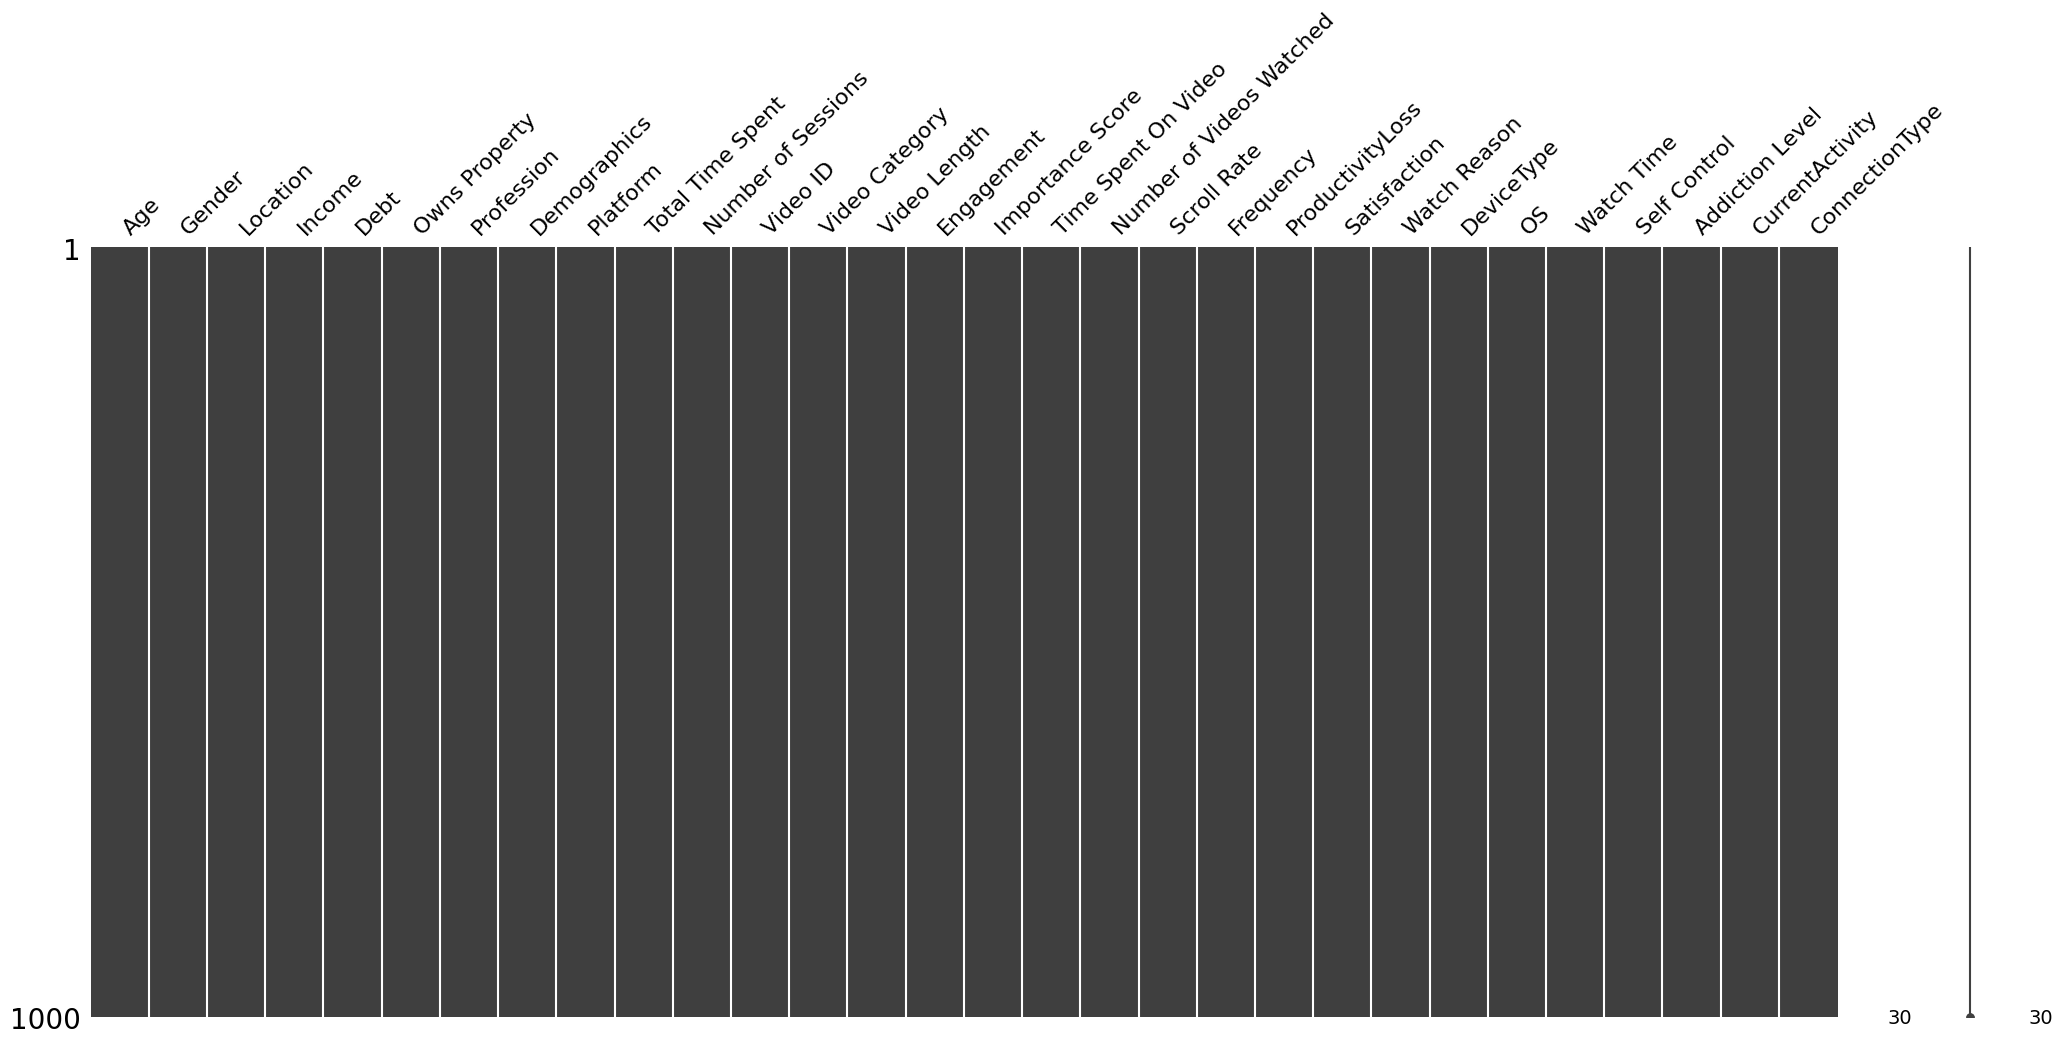

In [3]:
import missingno as msno

# Visualize the missing values in the dataframe
msno.matrix(df)

# Preprocessing

In [4]:
def good_one_hot(X, n_unique):

    X_copy = X.copy()  
    
    for col in X_copy.select_dtypes(include=['object', 'category']).columns:
        top_categories = X_copy[col].value_counts().nlargest(n_unique).index
        X_copy[col] = X_copy[col].where(X_copy[col].isin(top_categories), other="Other")
    
    X_encoded = pd.get_dummies(X_copy, columns=X_copy.select_dtypes(include=['object', 'category']).columns)
    
    return X_encoded

def add_interaction_terms(X):
    from itertools import combinations
    interaction_terms = pd.DataFrame(index=X.index)
    continuous_columns = X.select_dtypes(include=[np.number]).columns
    for col1, col2 in combinations(continuous_columns, 2):
        interaction_term_name = f"{col1}_x_{col2}"
        interaction_terms[interaction_term_name] = X[col1] * X[col2]
    return pd.concat([X, interaction_terms], axis=1)

df = good_one_hot(df, 100)

if 'ProductivityLoss' in df.columns:
    y = df['ProductivityLoss']
    y = pd.DataFrame({"Productivity Lost": y})
    y['Productivity Lost'] = y['Productivity Lost'].apply(lambda x: 0 if x < 5 else 1)
elif 'Productivity Lost' in df.columns:
    y = df['Productivity Lost']
    y = pd.DataFrame({"Productivity Lost": y})
    y['Productivity Lost'] = y['Productivity Lost'].apply(lambda x: 0 if x < 5 else 1)
else:
    print("No target column found in the dataset")

# x = df.drop(columns=['ProductivityLoss', 'Satisfaction', 'Addiction Level', 'Self Control'])
columns = ['ProductivityLoss', 'Satisfaction', 'Addiction Level', 'Self Control']
for column in columns:
    if column in df.columns:
        df = df.drop(columns=column)
        
if 'x' not in locals():
    x = df.copy()
    
x = add_interaction_terms(x)

if "Productivity Lost" in x.columns:
    x.drop("Productivity Lost", axis=1, inplace=True)

features = x.copy()
target = y.copy()

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Add these to the data folder for the AutoML portion
train = pd.concat([x_train, y_train], axis=1)
test = pd.concat([x_test, y_test], axis=1)
train.to_csv('./data/train.csv', index=False)
test.to_csv('./data/test.csv', index=False)

In [5]:
train.head()

Age  Income   Debt  Owns Property  Total Time Spent  Number of Sessions  \
29    44   57481   True          False               118                  10   
535   38   37858  False           True                91                   6   
695   45   48398  False          False               242                   2   
557   47   64014   True          False                54                   3   
836   46   91274   True          False                13                  13   

     Video ID  Video Length  Engagement  Importance Score  ...  \
29       4760             5        2160                 5  ...   
535      7397            20        8625                 4  ...   
695      9400            13        3291                 2  ...   
557      9612             8        7878                 7  ...   
836      9231            10        2940                 3  ...   

     Engagement_x_Time Spent On Video  Engagement_x_Number of Videos Watched  \
29                              34560                                  21600   
535                             25875                                 155250   
695                             85566                                   9873   
557                            141804                                 362388   
836                             23520                                 129360   

     Engagement_x_Scroll Rate  Importance Score_x_Time Spent On Video  \
29                     196560                                      80   
535                    560625                                      12   
695                    243534                                      52   
557                    165438                                     126   
836                    285180                                      24   

     Importance Score_x_Number of Videos Watched  \
29                                            50   
535                                           72   
695                                            6   
557                                          322   
836                                          132   

     Importance Score_x_Scroll Rate  \
29                              455   
535                             260   
695                             148   
557                             147   
836                             291   

     Time Spent On Video_x_Number of Videos Watched  \
29                                              160   
535                                              54   
695                                              78   
557                                             828   
836                                             352   

     Time Spent On Video_x_Scroll Rate  \
29                                1456   
535                                195   
695                               1924   
557                                378   
836                                776   

     Number of Videos Watched_x_Scroll Rate  Productivity Lost  
29                                      910                  1  
535                                    1170                  0  
695                                     222                  0  
557                                     966                  1  
836                                    4268                  0  

[5 rows x 143 columns]

# AutoML

Using AutoML to define what are some good model categories to try out

In [ ]:
import h2o
from h2o.automl import H2OAutoML

h2o.init(port = 54325, nthreads = -1, max_mem_size = "6g")
train = h2o.import_file("data/train.csv")
test = h2o.import_file("data/test.csv")
x = train.columns
y = "Productivity Lost"
if y in x:
    x.remove(y)
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
aml = H2OAutoML(max_models=100, max_runtime_secs=60, seed=1) 
aml.train(x=x, y=y, training_frame=train)
lb = aml.leaderboard
lb.head(rows=lb.nrows)

Checking whether there is an H2O instance running at http://localhost:54325. connected.


--------------------------  -----------------------------
H2O_cluster_uptime:         14 hours 47 mins
H2O_cluster_timezone:       America/Chicago
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.6
H2O_cluster_version_age:    23 days
H2O_cluster_name:           H2O_from_python_zfara_e6df1c
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    5.814 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54325
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.10.13 final
--------------------------  -----------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
15:07:16.932: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


model_id                                           auc    logloss     aucpr    mean_per_class_error      rmse       mse
--------------------------------------------  --------  ---------  --------  ----------------------  --------  --------
GBM_grid_1_AutoML_11_20241125_150716_model_7  0.885002   0.370097  0.921678                0.139316  0.33215   0.110324
GBM_4_AutoML_11_20241125_150716               0.883429   0.380401  0.921623                0.144942  0.338009  0.11425
GBM_grid_1_AutoML_11_20241125_150716_model_3  0.883237   0.382684  0.920805                0.153186  0.34104   0.116309
GBM_grid_1_AutoML_11_20241125_150716_model_2  0.881441   0.37251   0.910989                0.143995  0.333602  0.111291
GBM_5_AutoML_11_20241125_150716               0.880985   0.379166  0.912093                0.151181  0.335651  0.112662
GBM_grid_1_AutoML_11_20241125_150716_model_1  0.880884   0.391266  0.920705                0.166778  0.345452  0.119337
GBM_2_AutoML_11_20241125_150716               0.878753   0.38229   0.916638                0.141154  0.338524  0.114599
GBM_grid_1_AutoML_11_20241125_150716_model_5  0.877329   0.380886  0.916548                0.142101  0.337018  0.113581
GBM_3_AutoML_11_20241125_150716               0.876908   0.386688  0.91774                 0.148451  0.341663  0.116733
GLM_1_AutoML_11_20241125_150716               0.875599   0.396389  0.90708                 0.166778  0.346113  0.119794
DRF_1_AutoML_11_20241125_150716               0.868754   0.415032  0.904294                0.155916  0.355381  0.126296
GBM_grid_1_AutoML_11_20241125_150716_model_4  0.867637   0.403848  0.912295                0.167614  0.350766  0.123037
GBM_grid_1_AutoML_11_20241125_150716_model_6  0.842093   0.429155  0.893347                0.18037   0.362045  0.131077
DeepLearning_1_AutoML_11_20241125_150716      0.841087   0.491082  0.898526                0.247716  0.390602  0.15257
XRT_1_AutoML_11_20241125_150716               0.837671   0.489563  0.887205                0.230058  0.396562  0.157262
GBM_1_AutoML_11_20241125_150716               0.837153   0.422533  0.88443                 0.18037   0.35769   0.127942
[16 rows x 7 columns]

In [ ]:
# Display the top 25 models from the H2O AutoML leaderboard
lb.head(rows=25)

model_id                                           auc    logloss     aucpr    mean_per_class_error      rmse       mse
--------------------------------------------  --------  ---------  --------  ----------------------  --------  --------
GBM_grid_1_AutoML_11_20241125_150716_model_7  0.885002   0.370097  0.921678                0.139316  0.33215   0.110324
GBM_4_AutoML_11_20241125_150716               0.883429   0.380401  0.921623                0.144942  0.338009  0.11425
GBM_grid_1_AutoML_11_20241125_150716_model_3  0.883237   0.382684  0.920805                0.153186  0.34104   0.116309
GBM_grid_1_AutoML_11_20241125_150716_model_2  0.881441   0.37251   0.910989                0.143995  0.333602  0.111291
GBM_5_AutoML_11_20241125_150716               0.880985   0.379166  0.912093                0.151181  0.335651  0.112662
GBM_grid_1_AutoML_11_20241125_150716_model_1  0.880884   0.391266  0.920705                0.166778  0.345452  0.119337
GBM_2_AutoML_11_20241125_150716               0.878753   0.38229   0.916638                0.141154  0.338524  0.114599
GBM_grid_1_AutoML_11_20241125_150716_model_5  0.877329   0.380886  0.916548                0.142101  0.337018  0.113581
GBM_3_AutoML_11_20241125_150716               0.876908   0.386688  0.91774                 0.148451  0.341663  0.116733
GLM_1_AutoML_11_20241125_150716               0.875599   0.396389  0.90708                 0.166778  0.346113  0.119794
DRF_1_AutoML_11_20241125_150716               0.868754   0.415032  0.904294                0.155916  0.355381  0.126296
GBM_grid_1_AutoML_11_20241125_150716_model_4  0.867637   0.403848  0.912295                0.167614  0.350766  0.123037
GBM_grid_1_AutoML_11_20241125_150716_model_6  0.842093   0.429155  0.893347                0.18037   0.362045  0.131077
DeepLearning_1_AutoML_11_20241125_150716      0.841087   0.491082  0.898526                0.247716  0.390602  0.15257
XRT_1_AutoML_11_20241125_150716               0.837671   0.489563  0.887205                0.230058  0.396562  0.157262
GBM_1_AutoML_11_20241125_150716               0.837153   0.422533  0.88443                 0.18037   0.35769   0.127942
[16 rows x 7 columns]

Now it seems the main model architectures are 
1. Gradient Boosting Trees
2. Deep Learning
3. Random Forest

# MLFlow
Now let's do the MLFlow sections

In [16]:
# Required imports
import seaborn as sns
import shap
import mlflow
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

mlflow.set_experiment("Final Classification Experiment")

# Function to evaluate classification metrics
def classification_metrics(y_true, y_pred):
    
    y_pred = (y_pred > .5).astype(int)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    return accuracy, precision, recall, f1, roc_auc

global scaler

# Flexible experiment runner
def run_experiment(train, test, model, hyperparams=None):
    try:
        # Split input into features and target
        X_train, y_train = train
        X_test, y_test = test
        
        # Preprocessing
        scaler = StandardScaler()
        continuous_columns = X_train.select_dtypes(include=['float64', 'int64']).columns
        X_train[continuous_columns] = scaler.fit_transform(X_train[continuous_columns])
        X_test[continuous_columns] = scaler.transform(X_test[continuous_columns])

        # Add interaction terms (if applicable)
        X_train = X_train.apply(pd.to_numeric, errors='coerce')
        X_test = X_test.apply(pd.to_numeric, errors='coerce')

        # Configure model
        if hyperparams:
            model.set_params(**hyperparams)

        # Train the model
        model.fit(X_train, y_train)

        # Predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        # Metrics
        metrics_train = classification_metrics(y_train, y_pred_train)
        metrics_test = classification_metrics(y_test, y_pred_test)
        
        input_example = X_test.iloc[:5]

        # Log parameters and metrics to MLflow
        mlflow.start_run()
        mlflow.log_param("model", type(model).__name__)
        if hyperparams:
            mlflow.log_params(hyperparams)
        mlflow.log_metric("accuracy_train", metrics_train[0])
        mlflow.log_metric("accuracy_test", metrics_test[0])
        mlflow.log_metric("precision_train", metrics_train[1])
        mlflow.log_metric("precision_test", metrics_test[1])
        mlflow.log_metric("recall_train", metrics_train[2])
        mlflow.log_metric("recall_test", metrics_test[2])
        mlflow.log_metric("f1_train", metrics_train[3])
        mlflow.log_metric("f1_test", metrics_test[3])
        mlflow.log_metric("roc_auc_train", metrics_train[4])
        mlflow.log_metric("roc_auc_test", metrics_test[4])
        
        if isinstance(model, RandomForestClassifier):
            mlflow.sklearn.log_model(model, "model", input_example=input_example)
        elif isinstance(model, XGBClassifier):
            mlflow.xgboost.log_model(model, "model", input_example=input_example)
        elif isinstance(model, MLPClassifier):
            mlflow.sklearn.log_model(model, "model", input_example=input_example)
        else:
            print("Model not supported for logging")

        # Model-specific visualizations
        generate_model_explanations(model, X_train, X_test, y_test)

        # Confusion matrix
        generate_confusion_matrix(y_test, y_pred_test)

        # Precision-Recall curve and ROC curve
        generate_pr_roc_curves(model, X_test, y_test)

    except Exception as e:
        print(f"An error occurred: {e}")
        raise e

    finally:
        mlflow.end_run()
        return scaler


def generate_model_explanations(model, X_train, X_test, y_test):
    if isinstance(model, (RandomForestClassifier, XGBClassifier)):
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        shap.summary_plot(shap_values, X_test)
        mlflow.log_figure(plt.gcf(), "shap_summary_plot.png")
    elif isinstance(model, MLPClassifier):
        background = X_train.sample(n=100, random_state=0)
        def model_predict(X): return model.predict(X)
        explainer = shap.KernelExplainer(model_predict, background)
        shap_values = explainer.shap_values(X_test, nsamples=100)
        shap.summary_plot(shap_values, X_test)
        mlflow.log_figure(plt.gcf(), "shap_summary_plot.png")
    else:
        explainer = shap.Explainer(model.predict, X_train)
        shap_values = explainer.shap_values(X_test)
        shap.summary_plot(shap_values, X_test)
        mlflow.log_figure(plt.gcf(), "shap_summary_plot.png")


def generate_confusion_matrix(y_test, y_pred_test):
    cm = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    mlflow.log_figure(plt.gcf(), "confusion_matrix.png")


def generate_pr_roc_curves(model, X_test, y_test):
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.figure()
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()
    mlflow.log_figure(plt.gcf(), "precision_recall_curve.png")

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    mlflow.log_figure(plt.gcf(), "roc_curve.png")

/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Get our two different data versioning test sets

In [8]:
import subprocess

def run_command(command):
    result = subprocess.run(command, capture_output=True, text=True, check=True)
    print(result.stdout)
    

def checkout_dataset_version(version: str) -> None:
    """
    Checkout a specific version of the dataset using git and DVC, affecting only DVC-tracked data.
    """
    assert version in ['v1', 'v2'], "Version must be 'v1' or 'v2'."

    version_to_commit = {
        'v1': 'b054eedec2d083210755dc3bb3eff6edafb4109d',
        'v2': 'fbecb17d0ebfaf8f588d2cbaf399e25c1d4dd5b8',
    }

    checkout_hash = version_to_commit[version]

    # Limit git checkout to DVC-related files only
    dvc_files = [file for file in os.listdir(".") if file.endswith(".dvc")] + [".dvc"]
    for file in dvc_files:
        run_command(["git", "checkout", checkout_hash, "--", file])

    # Checkout dataset version with DVC
    run_command(["dvc", "checkout", "--force"])

## At this point I added dataset v1 do DVC using the command line

In [38]:
x_test['Age'].mean()

32.205

In [35]:
df_v2 = pd.read_csv(sorted(csv_files)[0])
if 'UserID' in df_v2.columns:
    df_v2.drop('UserID', axis=1, inplace=True)


# Modify the Age
df_v2['Age'] = np.random.permutation(df_v2['Age'].values) - 10
df_v2['Age'] = np.clip(df_v2['Age'], 18, 100) # Ensure age is within a reasonable range

# Modify the number of sessions, but keep it within the original range
prev_min = df['Number of Sessions'].min()
prev_max = df['Number of Sessions'].max()
df_v2['Number of Sessions'] = df_v2['Number of Sessions'] - df_v2['Number of Sessions'].std()
df_v2['Number of Sessions'] = np.clip(df_v2['Number of Sessions'], prev_min, prev_max)
df_v2['Number of Sessions'] = df_v2['Number of Sessions'].astype(int)

# Modify the time spent on video
prev_min = df['Number of Sessions'].min()
prev_max = df['Number of Sessions'].max()
df_v2['Time Spent On Video'] = df_v2['Time Spent On Video'] + df_v2['Time Spent On Video'].std()
df_v2['Time Spent On Video'] = np.clip(df_v2['Time Spent On Video'], prev_min, prev_max)
df_v2['Time Spent On Video'] = df_v2['Time Spent On Video'].astype(int)

In [36]:
df_v2 = good_one_hot(df_v2, 100)

if 'ProductivityLoss' in df_v2.columns:
    y = df_v2['ProductivityLoss']
    y = pd.DataFrame({"Productivity Lost": y})
    y['Productivity Lost'] = y['Productivity Lost'].apply(lambda x: 0 if x < 5 else 1)
elif 'Productivity Lost' in df_v2.columns:
    y = df_v2['Productivity Lost']
    y = pd.DataFrame({"Productivity Lost": y})
    y['Productivity Lost'] = y['Productivity Lost'].apply(lambda x: 0 if x < 5 else 1)
else:
    print("No target column found in the dataset")

columns = ['ProductivityLoss', 'Satisfaction', 'Addiction Level', 'Self Control']
for column in columns:
    if column in df_v2.columns:
        df_v2 = df_v2.drop(columns=column)
        
x = df_v2.copy()
    
x = add_interaction_terms(x)

if "Productivity Lost" in x.columns:
    x.drop("Productivity Lost", axis=1, inplace=True)

features = x.copy()
target = y.copy()

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Add these to the data folder for the AutoML portion
train = pd.concat([x_train, y_train], axis=1)
test = pd.concat([x_test, y_test], axis=1)
train.to_csv('./data/train.csv', index=False)
test.to_csv('./data/test.csv', index=False)

## At this point I added data version 2 to DVC

In [9]:
def load_data_version(version:str) -> pd.DataFrame:
    checkout_dataset_version(version)
    train = pd.read_csv('./data/train.csv')
    test = pd.read_csv('./data/test.csv')
    return train, test


In [40]:
train, test = load_data_version('v2')
test['Age'].mean()


32.205

In [28]:
import os
train, test = load_data_version('v1')
test['Age'].mean()
# Ad you can see they are different so we can saved the different data versions in DVC




M       data/



40.79

In [29]:
x_train = train.drop(columns=['Productivity Lost'])
y_train = train['Productivity Lost']
x_test = test.drop(columns=['Productivity Lost'])
y_test = test['Productivity Lost']

training_data = (x_train, y_train)
testing_data = (x_test, y_test)

# Run our experiments

Iteration 1/2
Hyperparameters: {'n_estimators': 750, 'max_depth': 2, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0.3, 'min_child_weight': 1, 'reg_alpha': 1.0, 'reg_lambda': 1.5, 'scale_pos_weight': 0.5151515151515151}


/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning:

[22:18:02] WARNING: /Users/runner/work/xgboost/xgboost/src/c

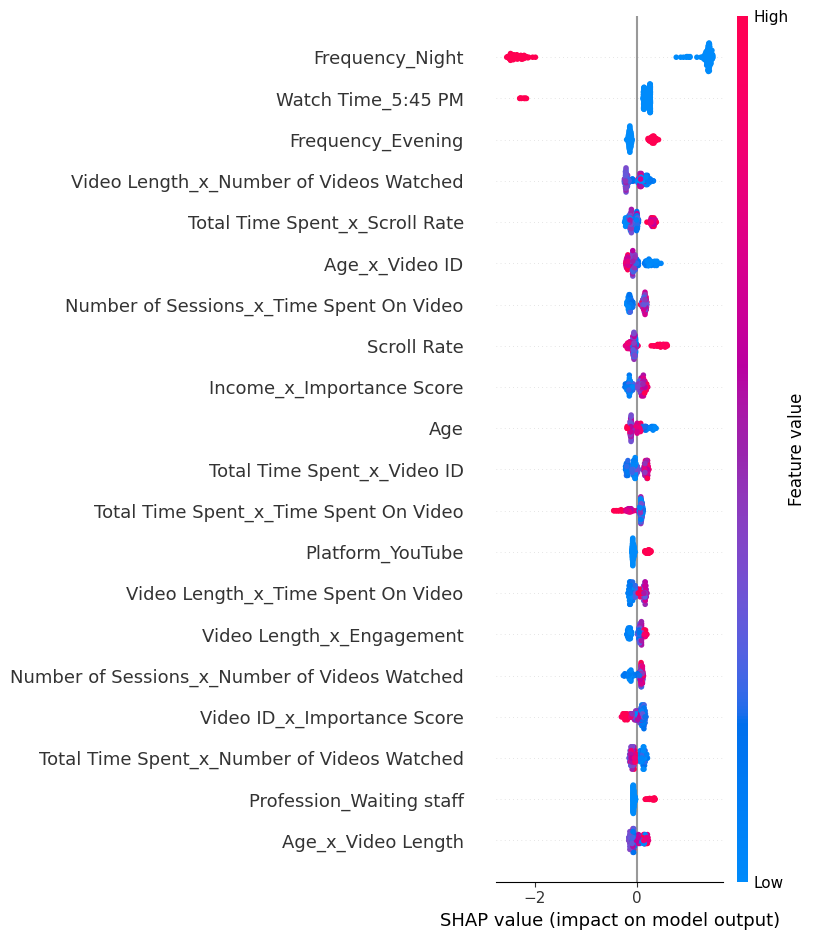

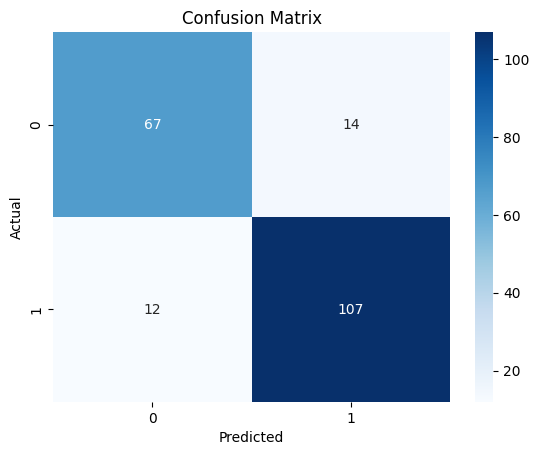

<Figure size 640x480 with 0 Axes>

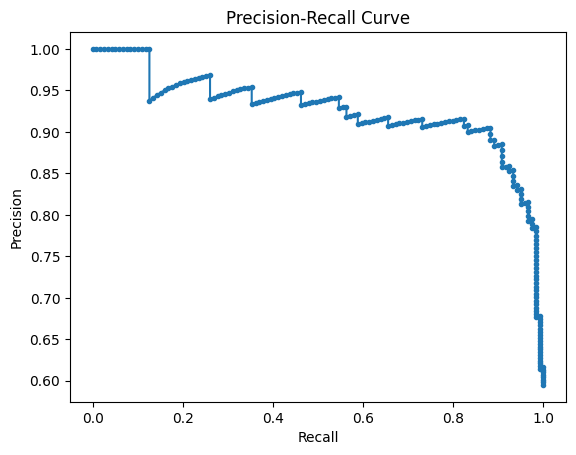

<Figure size 640x480 with 0 Axes>

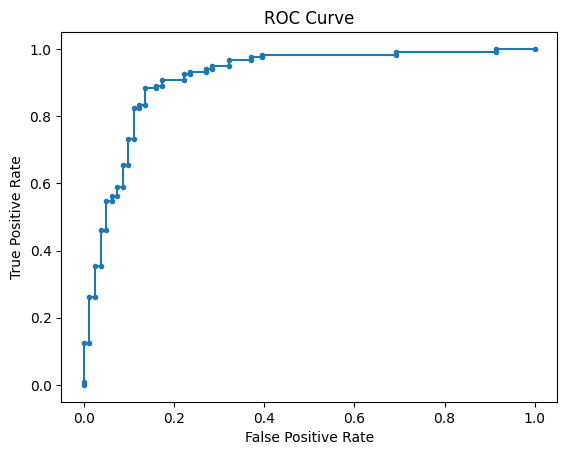

Iteration 2/2
Hyperparameters: {'n_estimators': 350, 'max_depth': 2, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 0.3, 'min_child_weight': 5, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'scale_pos_weight': None}


/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning:

[22:18:05] WARNING: /Users/runner/work/xgboost/xgboost/src/c

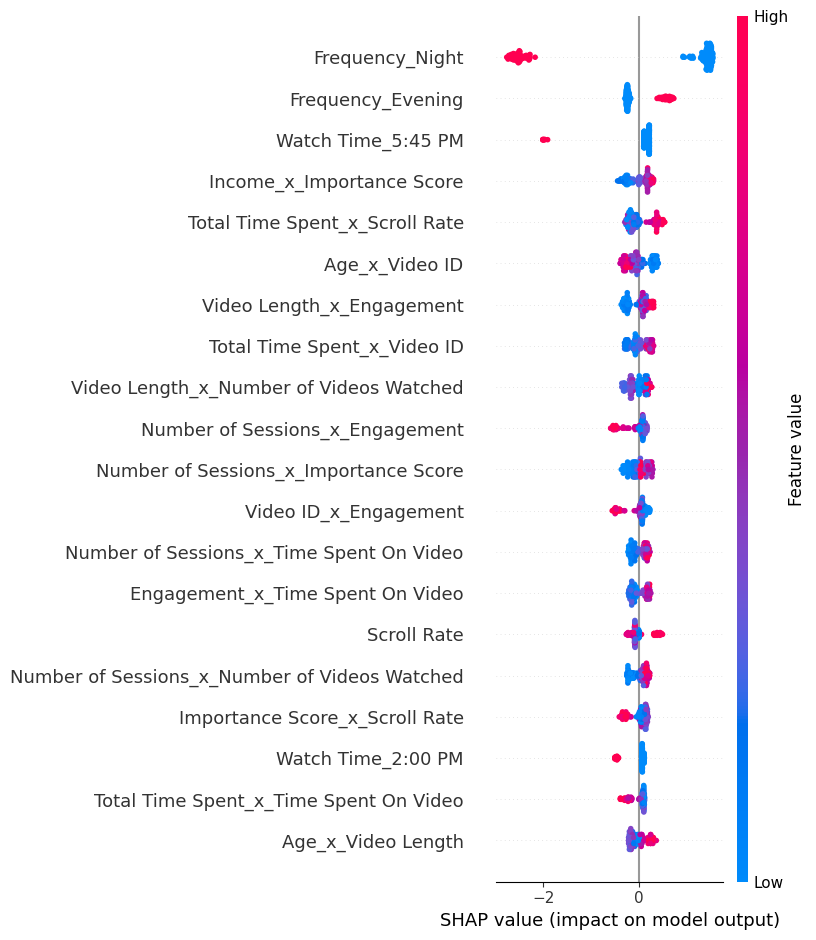

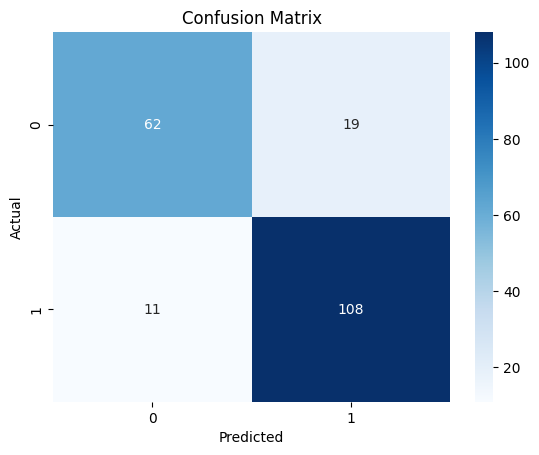

<Figure size 640x480 with 0 Axes>

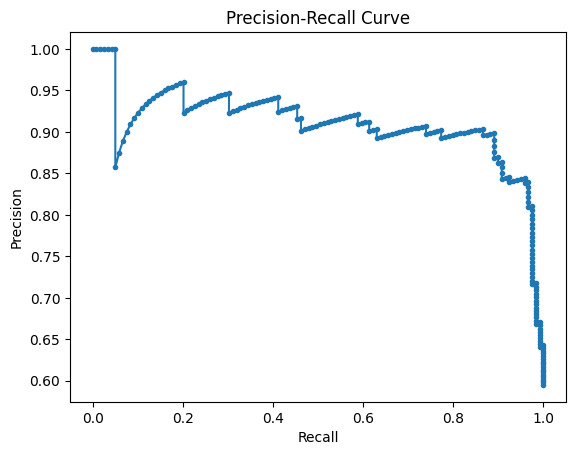

<Figure size 640x480 with 0 Axes>

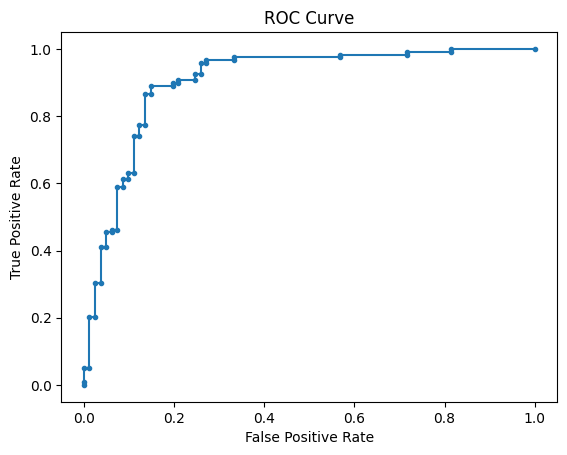

<Figure size 640x480 with 0 Axes>

In [30]:
from xgboost import XGBClassifier
import numpy as np

neg_class_count = (y_train == 0).sum()  # Count of negative samples
pos_class_count = (y_train == 1).sum()  # Count of positive samples
scale_pos_weight = float(neg_class_count / pos_class_count)

param_grid = {
    'n_estimators': list(range(50, 1000, 50)),  # Number of trees
    'max_depth': [2, 3, 5, 7, 9, 12],  # Maximum depth of trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Learning rate
    'subsample': [0.6, 0.8, 1.0],  # Subsample ratio of the training instances
    'colsample_bytree': [0.6, 0.8, 1.0],  # Subsample ratio of columns for each tree
    'gamma': [0, 0.1, 0.3, 0.5],  # Minimum loss reduction for further tree split
    'min_child_weight': [1, 3, 5],  # Minimum sum of instance weight (hessian) needed in a child
    'reg_alpha': [0, 0.01, 0.1, 1],  # L1 regularization term on weights
    'reg_lambda': [1, 1.5, 2, 5],  # L2 regularization term on weights
    'scale_pos_weight': [scale_pos_weight, None]  # Dynamically computed weight
}

xgb_model = XGBClassifier(random_state=0)

num_iterations = 2
for i in range(num_iterations):
    # Randomly sample hyperparameters
    hyperparams = {k: np.random.choice(v) for k, v in param_grid.items()}
    print(f"Iteration {i+1}/{num_iterations}")
    print("Hyperparameters:", hyperparams)
    scaler = run_experiment(train=training_data, test=testing_data, model=xgb_model, hyperparams=hyperparams)

import pickle
# Save the scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
    

Iteration 1/5
Hyperparameters: {'n_estimators': 300, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None}
Iteration 2/5
Hyperparameters: {'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None}


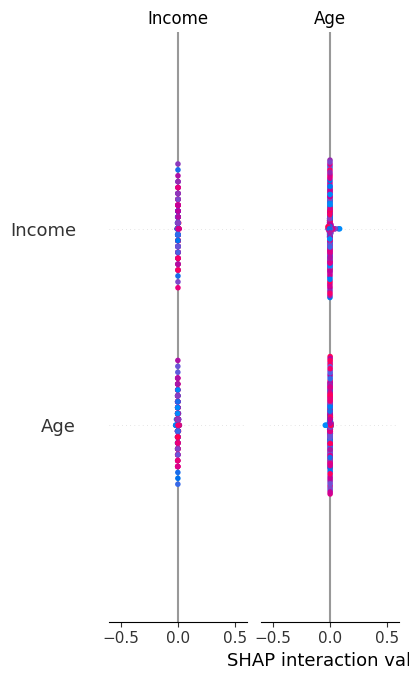

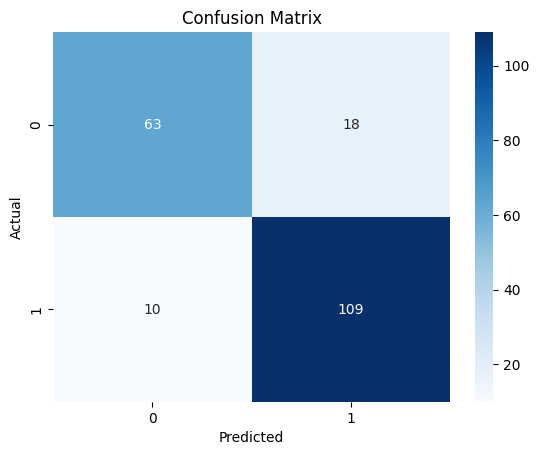

<Figure size 640x480 with 0 Axes>

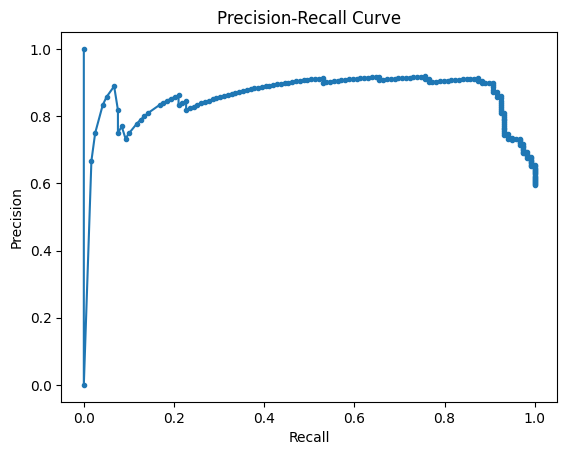

<Figure size 640x480 with 0 Axes>

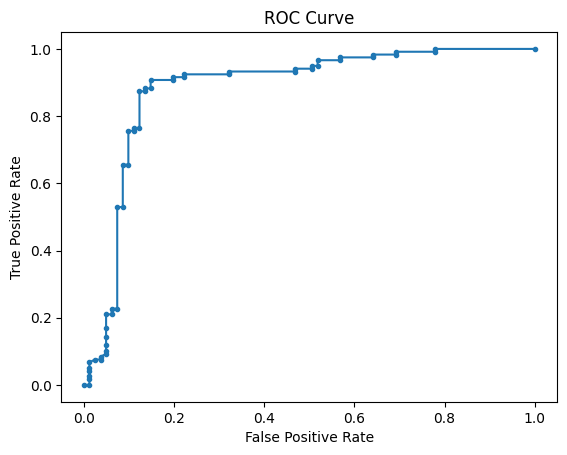

Iteration 3/5
Hyperparameters: {'n_estimators': 150, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None}


<Figure size 640x480 with 0 Axes>

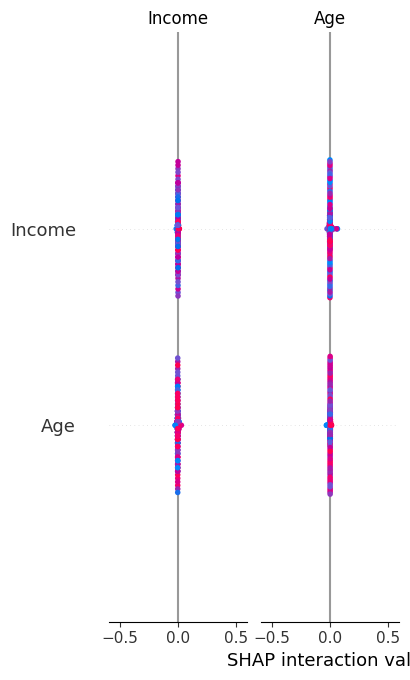

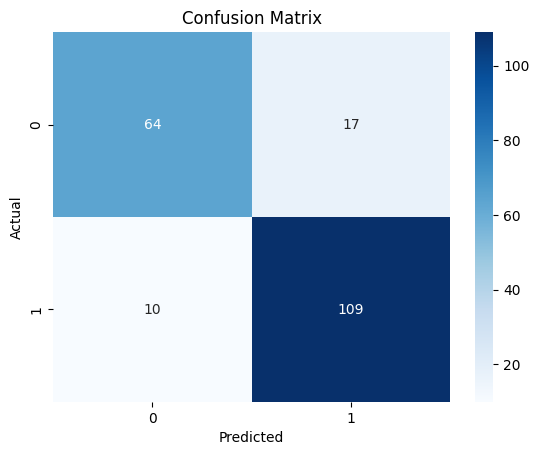

<Figure size 640x480 with 0 Axes>

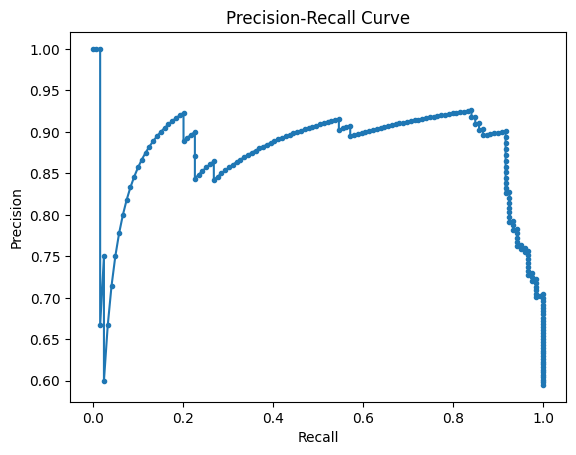

<Figure size 640x480 with 0 Axes>

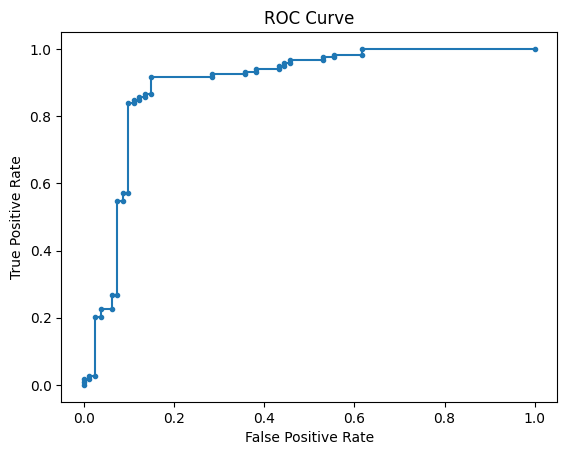

Iteration 4/5
Hyperparameters: {'n_estimators': 250, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt'}


<Figure size 640x480 with 0 Axes>

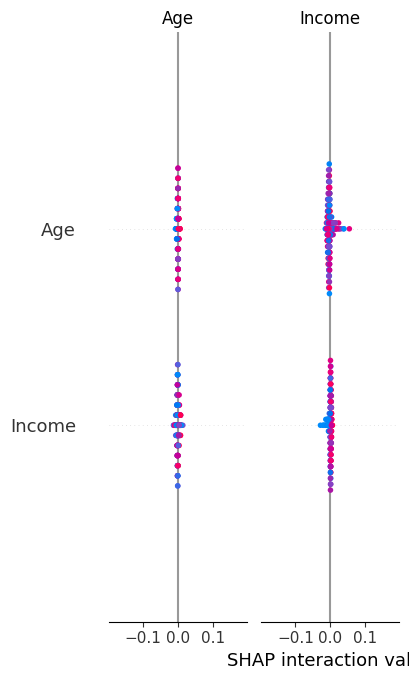

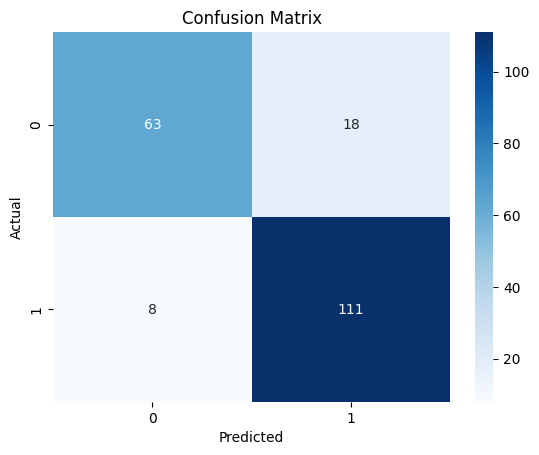

<Figure size 640x480 with 0 Axes>

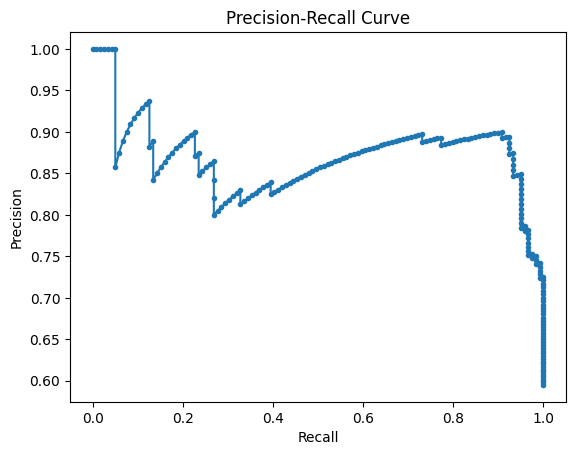

<Figure size 640x480 with 0 Axes>

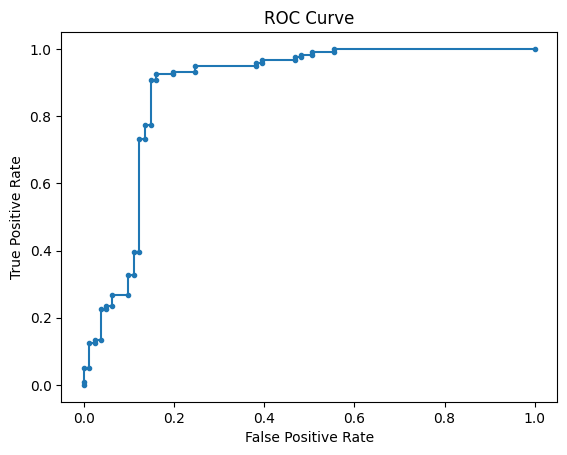

Iteration 5/5
Hyperparameters: {'n_estimators': 550, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}


<Figure size 640x480 with 0 Axes>

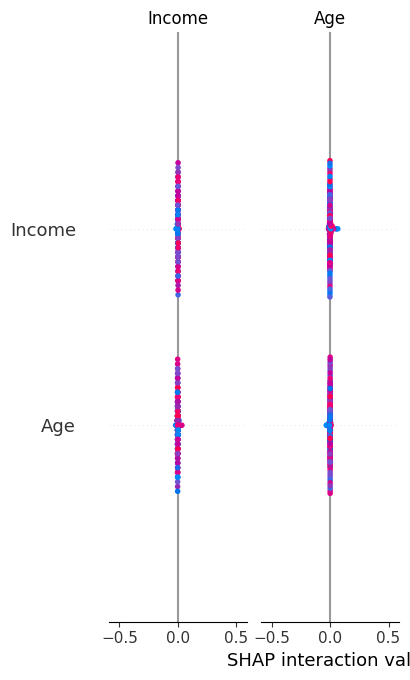

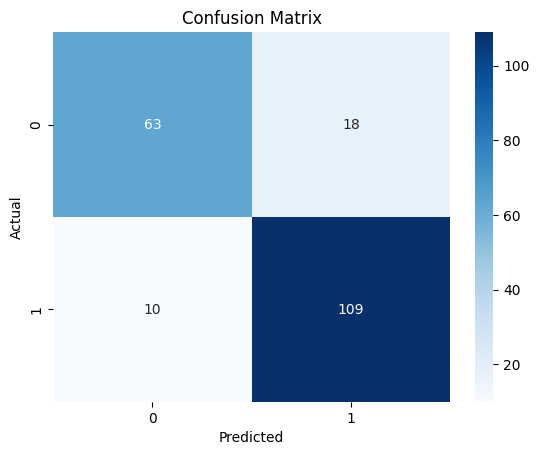

<Figure size 640x480 with 0 Axes>

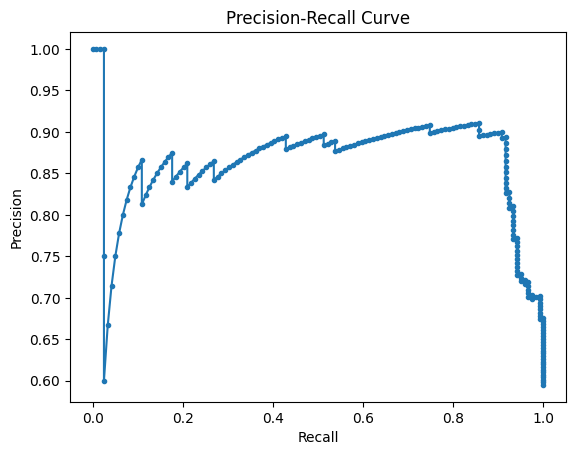

<Figure size 640x480 with 0 Axes>

In [44]:
rf_model = RandomForestClassifier(random_state=0)

param_grid = {
    'n_estimators': list(range(50, 1000, 50)),  # Number of trees
    'max_depth': [2, 3, 5, 7, 9, 12],  # Maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': [None, 'sqrt', 'log2']  # Number of features to consider when looking for the best split
}

num_iterations = 5
for i in range(num_iterations):
    # Randomly sample hyperparameters
    hyperparams = {k: np.random.choice(v) for k, v in param_grid.items()}
    print(f"Iteration {i+1}/{num_iterations}")
    print("Hyperparameters:", hyperparams)
    scaler = run_experiment(train=training_data, test=testing_data, model=rf_model, hyperparams=hyperparams)


Iteration 1/2
Hyperparameters: {'hidden_layer_sizes': (100, 100), 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate_init': 0.05757142857142858, 'max_iter': 400}


/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
  0%|          | 0/200 [00:00<?, ?it/s]/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
  0%|          | 1/200 [00:00<01:11,  2.78it/s]/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier w

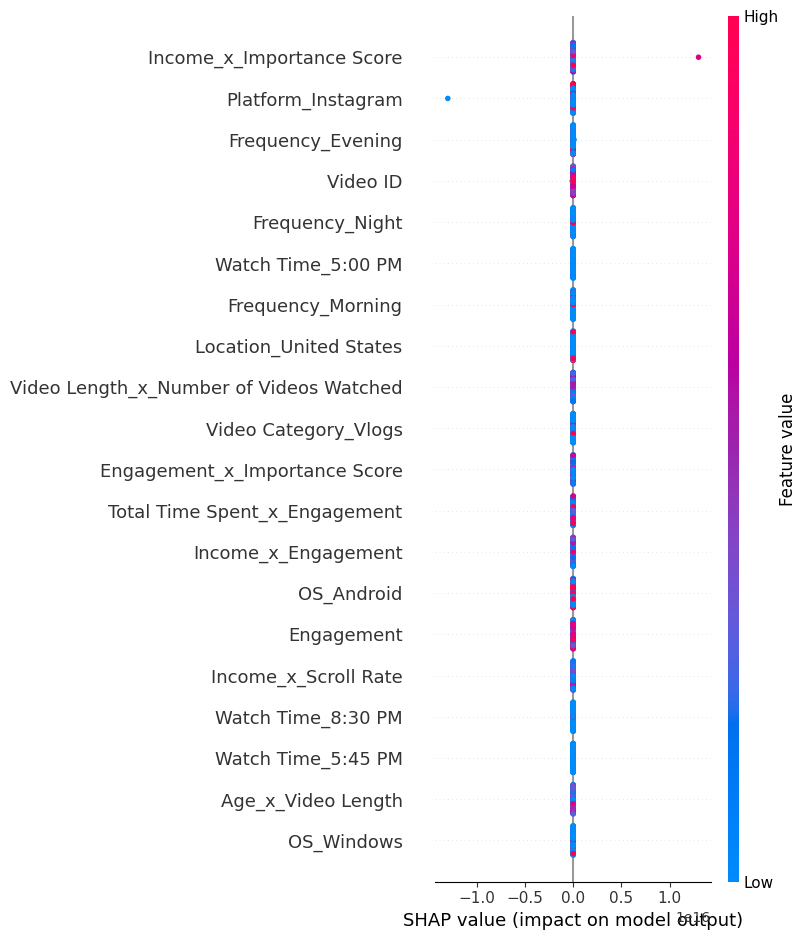

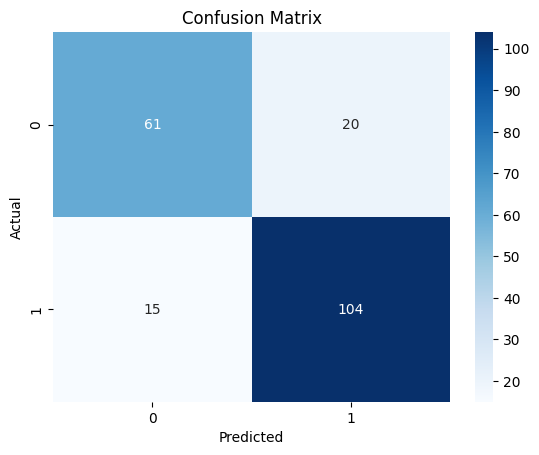

<Figure size 640x480 with 0 Axes>

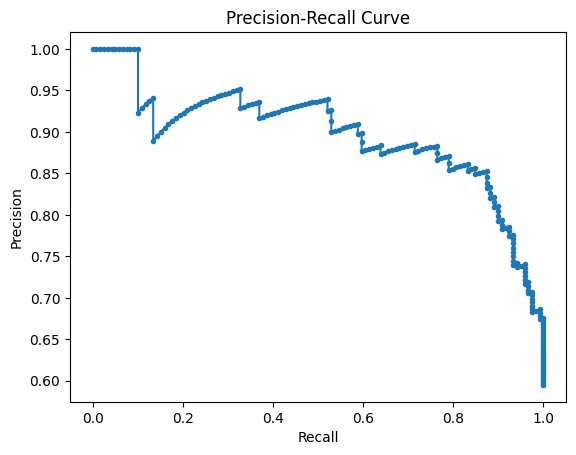

<Figure size 640x480 with 0 Axes>

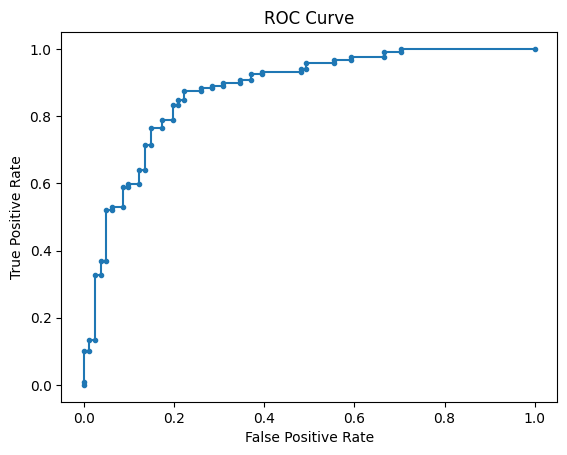

Iteration 2/2
Hyperparameters: {'hidden_layer_sizes': (100, 50), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate_init': 0.0959591836734694, 'max_iter': 300}


/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
  0%|          | 0/200 [00:00<?, ?it/s]/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
  0%|          | 1/200 [00:00<01:18,  2.52it/s]/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier w

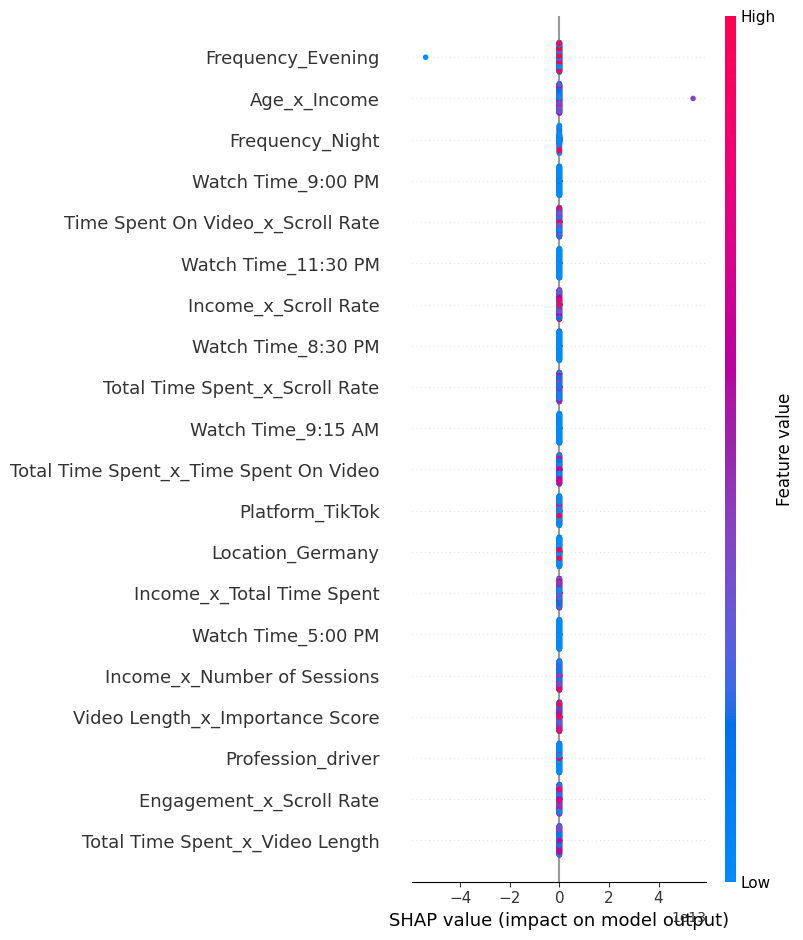

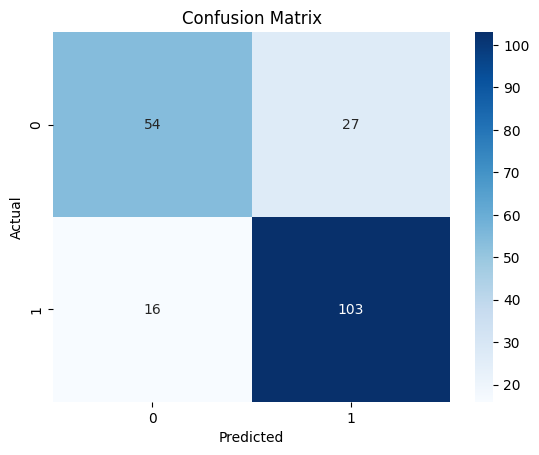

<Figure size 640x480 with 0 Axes>

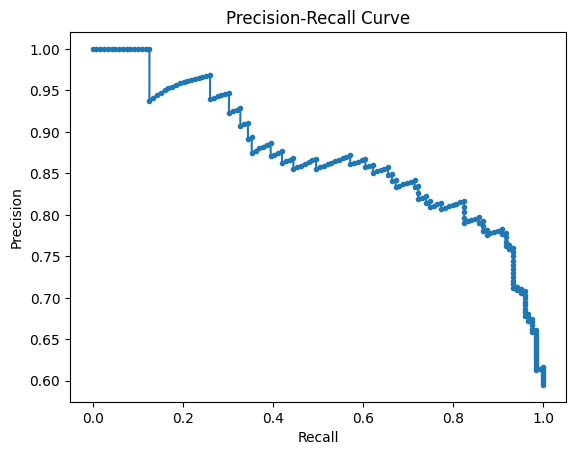

<Figure size 640x480 with 0 Axes>

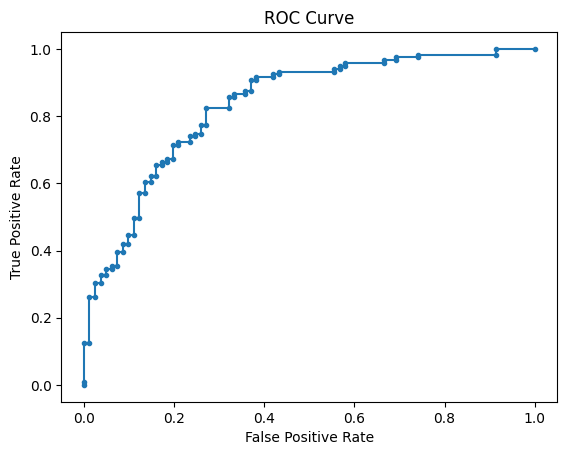

<Figure size 640x480 with 0 Axes>

In [ ]:
mlp_model = MLPClassifier(random_state=0)

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': np.linspace(0.001, 0.1, 50),  # Fix learning rate range
    'max_iter': [200, 300, 400]
}

import random

num_iterations = 2
for i in range(num_iterations):
    hyperparams = {k: random.choice(v) for k, v in param_grid.items()}
    print(f"Iteration {i+1}/{num_iterations}")
    print("Hyperparameters:", hyperparams)
    scaler = run_experiment(train=training_data, test=testing_data, model=mlp_model, hyperparams=hyperparams)

# Model Deployment

In [18]:
import mlflow
from mlflow.tracking import MlflowClient
from mlflow.pyfunc import load_model

def get_best_model(metric="test_f1", experiment_name="Final Classification Experiment"):
    """
    Retrieves the best model from the specified MLflow experiment based on the given metric.
    
    Args:
        metric (str): The metric to base the selection on (default is "test_f1").
        experiment_name (str): The name of the MLflow experiment.
    
    Returns:
        dict: Information about the best run and the loaded model.
    """
    client = MlflowClient()
    
    # Get the experiment ID by name
    experiment = client.get_experiment_by_name(experiment_name)
    if not experiment:
        raise ValueError(f"Experiment '{experiment_name}' not found.")
    
    # Search runs within the experiment
    runs = client.search_runs(
        experiment_ids=[experiment.experiment_id],
        order_by=[f"metrics.{metric} DESC"],
        max_results=1
    )
    
    if not runs:
        raise ValueError(f"No runs found in experiment '{experiment_name}' with metric '{metric}'.")
    
    best_run = runs[0]
    best_metric = best_run.data.metrics.get(metric, None)
    
    # Extract model URI and load the model
    model_uri = f"runs:/{best_run.info.run_id}/model"
    model = load_model(model_uri)
    
    print(f"Best model found in experiment '{experiment_name}' with {metric}={best_metric}, run_id={best_run.info.run_id}")
    return {"model": model, "run_id": best_run.info.run_id, "metric": best_metric}

In [19]:
best_model_info = get_best_model(metric="f1_test", experiment_name="Final Classification Experiment")
print(best_model_info)

Best model found in experiment 'Final Classification Experiment' with f1_test=0.9, run_id=f2a72387ace24d1ea010016c79d3ba9e
{'model': mlflow.pyfunc.loaded_model:
  artifact_path: model
  flavor: mlflow.xgboost
  run_id: f2a72387ace24d1ea010016c79d3ba9e
, 'run_id': 'f2a72387ace24d1ea010016c79d3ba9e', 'metric': 0.9}


In [20]:
import mlflow.pyfunc
run_id = best_model_info['run_id']
try:
    model = mlflow.pyfunc.load_model(f"mlruns/150011855340888941/{run_id}/artifacts/model")
    success = True
except Exception as e:
    print(f"An error occurred: {e}")
    success = False

In [40]:
import subprocess

def serve_model(run_id, port):
    cmd = [
        "mlflow", "models", "serve",
        "-m", f"mlruns/150011855340888941/{run_id}/artifacts/model",
        "--port", str(port), "--env-manager=local"
    ]
    print("Running command:", " ".join(cmd))
    subprocess.Popen(cmd)

serve_model(run_id, 5007)

Running command: mlflow models serve -m mlruns/150011855340888941/f2a72387ace24d1ea010016c79d3ba9e/artifacts/model --port 5007 --env-manager=local


2024/12/10 22:50:11 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'
2024/12/10 22:50:11 INFO mlflow.pyfunc.backend: === Running command 'exec gunicorn --timeout=60 -b 127.0.0.1:5007 -w 1 ${GUNICORN_CMD_ARGS} -- mlflow.pyfunc.scoring_server.wsgi:app'
[2024-12-10 22:50:11 -0600] [91663] [INFO] Starting gunicorn 23.0.0
[2024-12-10 22:50:11 -0600] [91663] [INFO] Listening at: http://127.0.0.1:5007 (91663)
[2024-12-10 22:50:11 -0600] [91663] [INFO] Using worker: sync
[2024-12-10 22:50:11 -0600] [91664] [INFO] Booting worker with pid: 91664


In [49]:
import requests
import pandas as pd

def format_and_invoke(df, scaler, endpoint="http://127.0.0.1:5007/invocations"):
    continuous_columns = df.select_dtypes(include=['float64', 'int64']).columns
    df[continuous_columns] = scaler.transform(df[continuous_columns])
    df = df.apply(pd.to_numeric, errors='coerce')
    payload = {
        "dataframe_split": {
            "columns": df.columns.tolist(),
            "data": df.values.tolist()
        }
    }
    response = requests.post(endpoint, json=payload)
    return response

response = format_and_invoke(x_test, scaler)
print(response.json())

ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=5007): Max retries exceeded with url: /invocations (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x309949a80>: Failed to establish a new connection: [Errno 61] Connection refused'))

In [47]:
# Load the dataset version v2
train, test = load_data_version('v1')
x_test = test.drop(columns=['Productivity Lost'])
y_test = test['Productivity Lost']

print(f"If this is 40.79 then we are using V1: {x_test['Age'].mean()}")

# Get the metrics using the best model
response = format_and_invoke(x_test, scaler)
predictions_v1 = np.array(response.json()['predictions'])
accuracy, precision, recall, f1, roc_auc = classification_metrics(y_test,predictions_v1)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")




M       data/

If this is 40.79 then we are using V1: 40.79
Accuracy: 0.6150
Precision: 0.8387
Recall: 0.4370
F1 Score: 0.5746
ROC AUC: 0.6568


In [48]:
# Load the dataset version v2
train, test = load_data_version('v2')
x_test = test.drop(columns=['Productivity Lost'])
y_test = test['Productivity Lost']

print(f"If this is 40.79 then we are using V1: {x_test['Age'].mean()}")

# Get the metrics using the best model
response = format_and_invoke(x_test, scaler)
predictions_v2 = np.array(response.json()['predictions'])
accuracy, precision, recall, f1, roc_auc = classification_metrics(y_test,predictions_v2)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")




M       data/

If this is 40.79 then we are using V1: 32.205
Accuracy: 0.6150
Precision: 0.8387
Recall: 0.4370
F1 Score: 0.5746
ROC AUC: 0.6568


Traceback (most recent call last):
  File "/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/bin/mlflow", line 8, in <module>
    sys.exit(cli())
  File "/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/click/core.py", line 1157, in __call__
    return self.main(*args, **kwargs)
  File "/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/click/core.py", line 1078, in main
    rv = self.invoke(ctx)
  File "/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/click/core.py", line 1688, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/click/core.py", line 1688, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/Users/zfara/Repositories/UChicago/MLOps/

# Model Monitoring

In [44]:
import copy
# Get current data and reference data

# Load the dataset version v1
train, test = load_data_version('v1')

reference_data =copy.deepcopy(test)

train, test = load_data_version('v2')

current_data = copy.deepcopy(test)




M       data/




M       data/



In [46]:
import os
from evidently.report import Report
from evidently.metrics import DataDriftTable, ClassificationQualityByClass
from evidently import ColumnMapping
from pathlib import Path

cwd = Path(os.getcwd())

column_mapping = ColumnMapping(
    target="Productivity Lost",  
    prediction="predictions"  
)

# These might have gotten set during previous iterations
if 'predictions' in current_data.columns:
    current_data.drop('predictions', axis=1, inplace=True)
    
if 'predictions' in reference_data.columns:
    reference_data.drop('predictions', axis=1, inplace=True)

current_data["predictions"] = xgb_model.predict(current_data.drop('Productivity Lost', axis=1))
reference_data['predictions'] = xgb_model.predict(reference_data.drop('Productivity Lost', axis=1))

# Show the report in the Jupyter Notebook
report = Report(metrics=[
    DataDriftTable(), 
    ClassificationQualityByClass()
])

report.run(reference_data=reference_data, current_data=current_data, column_mapping=column_mapping)
os.makedirs(cwd / 'reports', exist_ok=True)
report.save_html(str(cwd / 'reports' / 'report_A.html'))
report.show()